In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.utils import np_utils
%matplotlib inline

Using TensorFlow backend.


In [2]:
#定義類別與其整數對應

class_mapping = {'CNV': 0,'DME': 1,'DRUSEN': 2,'NORMAL': 3}

In [3]:
#讀取每張圖片，與其標籤
# OpenCV 本身就有提供讀取圖片檔的函數可用，讀取一般的圖片檔，只要呼叫 cv2.imread 即可將圖片讀取進來
# 以 cv2.imread 讀進來的資料，會儲存成一個 NumPy 的陣列

#  在OpenCV中，图像不是用常规的RGB颜色通道来存储的，它们用的是BGR顺序。当读取一幅图像后，
#  默认的是BGR，不过有很多转换方式是可以利用的。颜色空间转换可以用函数cvtColor()函数

# # 使用 OpenCV 讀取圖檔
# img_bgr = cv2.imread('image.jpg')

# # 將 BGR 圖片轉為 RGB 圖片
# img_rgb = img_bgr[:,:,::-1]

# # 或是這樣亦可
# # img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# # 使用 Matplotlib 顯示圖片
# plt.imshow(img_rgb)
# plt.show()


img_paths = glob.glob('/home/jovyan/Final_Project_Classification/train/*/*.jpeg')
images, labels = [], []
img_sizes = []
for img_path in img_paths:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))
    if img.shape not in img_sizes:
        img_sizes.append(img.shape)
    label = img_path.split('/')[-2]
    label = class_mapping.get(label)
    images.append(img)
    labels.append(label)
images = np.array(images)
labels = np.uint8(labels)

In [4]:
images.shape

(2203, 299, 299, 3)

In [5]:
x_Train4D = images.reshape(images.shape[0],299, 299,3).astype('float32') 
x_Train4D.shape

(2203, 299, 299, 3)

In [6]:
x_Train4D_normalize = x_Train4D/255

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train_1, y_valid_1 = train_test_split(x_Train4D_normalize, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    )

In [8]:
y_train = np_utils.to_categorical(y_train_1)
y_valid = np_utils.to_categorical(y_valid_1)

In [9]:
X_train.shape

(1762, 299, 299, 3)

In [10]:
y_train.shape

(1762, 4)

In [11]:
X_valid.shape

(441, 299, 299, 3)

In [12]:
y_valid.shape

(441, 4)

In [13]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.xception import Xception

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [14]:
model_name = 'Xception-Fine-Tune'
num_classes = 4

img_rows, img_cols, img_channel = 299, 299, 3
base_model = Xception(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [15]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

epochs = 100
batch_size = 10

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Epoch 1/100
176/177 [============================>.] - ETA: 0s - loss: 1.2139 - accuracy: 0.4635
Epoch 00001: val_loss improved from inf to 1.07443, saving model to ./saved_models/Xception-Fine-Tune.h5
177/177 [==============================] - 63s 355ms/step - loss: 1.2125 - accuracy: 0.4648 - val_loss: 1.0744 - val_accuracy: 0.6961
Epoch 2/100
176/177 [============================>.] - ETA: 0s - loss: 0.7075 - accuracy: 0.8151
Epoch 00002: val_loss improved from 1.07443 to 0.59387, saving model to ./saved_models/Xception-Fine-Tune.h5
177/177 [==============================] - 61s 344ms/step - loss: 0.7079 - accuracy: 0.8144 - val_loss: 0.5939 - val_accuracy: 0.9161
Epoch 3/100
176/177 [============================>.] - ETA: 0s - loss: 0.3796 - accuracy: 0.9001
Epoch 00003: val_loss improved from 0.59387 to 0.30960, saving model to ./saved_models/Xception-Fine-Tune.h5
177/177 [==============================] - 62s 348ms/step - loss: 0.3794 - accuracy: 0.9001 - val_loss: 0.3096 - val_a

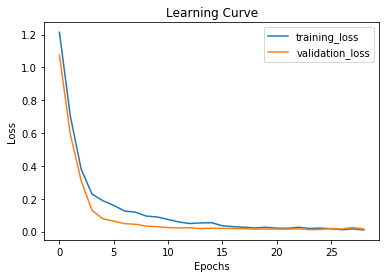

In [16]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

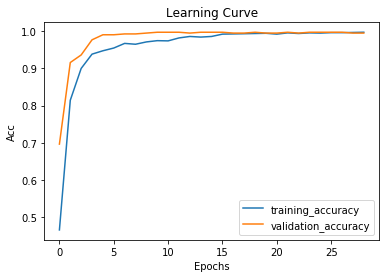

In [18]:
training_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

# Vilidation Set 預測錯誤分析

In [20]:
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

441/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [21]:
X_valid_prediction = model.predict(X_valid)
prediction_X_valid = X_valid_prediction.argmax(axis=-1)

In [22]:
prediction_X_valid

array([1, 2, 3, 3, 3, 0, 1, 0, 1, 1, 3, 0, 2, 1, 3, 2, 3, 0, 0, 2, 0, 2,
       2, 1, 0, 0, 0, 0, 2, 3, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 0, 2, 2, 3,
       1, 3, 0, 2, 1, 3, 3, 2, 2, 0, 0, 1, 3, 3, 2, 2, 1, 1, 1, 0, 2, 2,
       3, 3, 2, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 0, 3, 2, 2, 3, 0, 0, 3,
       0, 3, 1, 3, 0, 0, 2, 1, 3, 1, 2, 2, 3, 3, 2, 3, 1, 1, 1, 0, 2, 2,
       1, 2, 3, 2, 2, 0, 2, 0, 0, 3, 3, 2, 2, 3, 3, 3, 2, 0, 3, 3, 2, 1,
       0, 1, 3, 2, 2, 2, 2, 2, 3, 0, 2, 3, 2, 3, 0, 3, 2, 0, 3, 1, 0, 3,
       3, 3, 2, 3, 2, 2, 0, 0, 2, 2, 2, 3, 2, 2, 2, 2, 0, 3, 1, 0, 0, 2,
       1, 3, 0, 0, 3, 3, 3, 3, 1, 1, 0, 2, 0, 3, 1, 0, 3, 0, 1, 3, 1, 0,
       3, 1, 0, 2, 3, 3, 1, 2, 1, 1, 2, 2, 3, 0, 2, 3, 1, 0, 0, 0, 3, 3,
       2, 3, 1, 3, 0, 3, 3, 1, 2, 0, 0, 0, 3, 3, 1, 1, 0, 2, 0, 2, 0, 3,
       1, 0, 3, 3, 2, 3, 3, 0, 0, 1, 2, 2, 3, 0, 3, 1, 2, 2, 2, 0, 0, 2,
       2, 3, 1, 0, 1, 3, 3, 0, 3, 0, 1, 2, 3, 0, 3, 3, 0, 3, 3, 1, 3, 0,
       1, 0, 1, 2, 0, 1, 3, 1, 0, 2, 0, 1, 0, 1, 3,

In [23]:
import pandas as pd
pd.crosstab(y_valid_1,prediction_X_valid, rownames=['label'],colnames=['predict'])

predict,0,1,2,3
label,,,,
0,117,0,0,0
1,0,87,0,0
2,0,0,112,0
3,0,0,1,124


In [24]:
df = pd.DataFrame({'label':y_valid_1 , 'predict':prediction_X_valid})

In [25]:
class_mapping = {'CNV': 0,'DME': 1,'DRUSEN': 2,'NORMAL': 3}
inv_mapping = {v: k for k , v in class_mapping.items()}
inv_mapping

{0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}

In [26]:
label_1 = []
for i in range(len(df)) :
    aa = inv_mapping[df['label'][i]]
    label_1.append(aa)  

In [27]:
label_1 = pd.DataFrame(label_1 , columns = ['label_1'])
df = pd.concat([df , label_1] , axis=1)
df

,label,predict,label_1
0,1,1,DME
1,2,2,DRUSEN
2,3,3,NORMAL
3,3,3,NORMAL
4,3,3,NORMAL
...,...,...,...
436,1,1,DME
437,3,3,NORMAL
438,0,0,CNV
439,3,3,NORMAL


In [28]:
predict_1 = []
for i in range(len(df)) :
    aa = inv_mapping[df['predict'][i]]
    predict_1.append(aa)  

In [29]:
predict_1 = pd.DataFrame(predict_1 , columns = ['predict_1'])
df = pd.concat([df , predict_1] , axis=1)
df

,label,predict,label_1,predict_1
0,1,1,DME,DME
1,2,2,DRUSEN,DRUSEN
2,3,3,NORMAL,NORMAL
3,3,3,NORMAL,NORMAL
4,3,3,NORMAL,NORMAL
...,...,...,...,...
436,1,1,DME,DME
437,3,3,NORMAL,NORMAL
438,0,0,CNV,CNV
439,3,3,NORMAL,NORMAL


In [30]:
pd.crosstab(df['label_1'],df['predict_1'], rownames=['label'],colnames=['predict'])

predict,CNV,DME,DRUSEN,NORMAL
label,,,,
CNV,117,0,0,0
DME,0,87,0,0
DRUSEN,0,0,112,0
NORMAL,0,0,1,124


In [31]:
df_wrong = df[df.label_1!=df.predict_1]
df_wrong 

,label,predict,label_1,predict_1
139,3,2,NORMAL,DRUSEN


In [32]:
wrongindex = df_wrong.index
wrongindex

Int64Index([139], dtype='int64')

In [34]:
# df_wrong['label_1'].iloc[1] , df_wrong['predict_1'].iloc[1] , wrongindex[1]

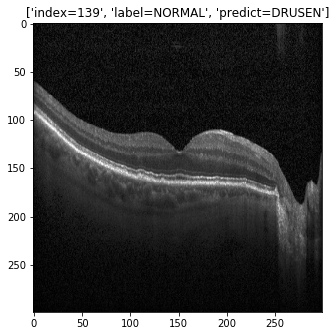

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
for i in range(len(wrongindex)) :
    plt.subplot(int(len(wrongindex)/5)+1 , 5, i+1 )
    plt.imshow(X_valid[wrongindex[i]])   
    plt.gca().set_title(["index=" +str(wrongindex[i]),"label=" +str(df_wrong['label_1'].iloc[i]),"predict=" +str(df_wrong['predict_1'].iloc[i])])      

In [36]:
pd.crosstab(df['label_1'],df['predict_1'], rownames=['label'],colnames=['predict'])

predict,CNV,DME,DRUSEN,NORMAL
label,,,,
CNV,117,0,0,0
DME,0,87,0,0
DRUSEN,0,0,112,0
NORMAL,0,0,1,124


In [37]:
mapping = {'CNV': 0,'DME': 1,'DRUSEN': 2,'NORMAL': 3}

Text(91.68, 0.5, 'label')

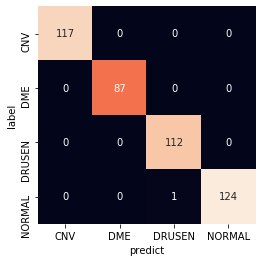

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_valid_1 , prediction_X_valid)
sns.heatmap(mat,square=True,annot=True,fmt='d',cbar=False,
           xticklabels=mapping , yticklabels=mapping)
plt.xlabel('predict')
plt.ylabel('label')

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_valid_1 , prediction_X_valid , target_names=mapping))

              precision    recall  f1-score   support

         CNV       1.00      1.00      1.00       117
         DME       1.00      1.00      1.00        87
      DRUSEN       0.99      1.00      1.00       112
      NORMAL       1.00      0.99      1.00       125

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441



# 預測 New Data

In [1]:
from tensorflow.keras.models import Sequential, load_model, Model
model = load_model("./saved_models/Xception-Fine-Tune.h5")

In [15]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.utils import np_utils

class_mapping = {'CNV': 0,'DME': 1,'DRUSEN': 2,'NORMAL': 3}

img_paths = glob.glob('/home/jovyan/Final_Project_Classification/new_data/*/*.jpeg')
new_images, new_labels = [], []
img_sizes = []
for img_path in img_paths:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))
    if img.shape not in img_sizes:
        img_sizes.append(img.shape)
    label = img_path.split('/')[-2]
    label = class_mapping.get(label)
    new_images.append(img)
    new_labels.append(label)
new_images = np.array(new_images)
new_labels = np.uint8(new_labels)


In [16]:
x_new_images = new_images.reshape(new_images.shape[0],299,299,3).astype('float32') 

In [17]:
x_new_images_normalize = x_new_images/255

In [18]:
y_test_pred_prob = model.predict(x_new_images_normalize)
prediction = y_test_pred_prob.argmax(axis=-1)

In [19]:
import pandas as pd
pd.crosstab(new_labels,prediction, rownames=['label'],colnames=['predict'])

predict,0,1,2,3
label,,,,
0,98,2,0,0
1,0,100,0,0
2,2,0,98,0
3,0,0,0,100


In [20]:
new_df = pd.DataFrame({'label':new_labels , 'predict':prediction})

class_mapping = {'CNV': 0,'DME': 1,'DRUSEN': 2,'NORMAL': 3}
inv_mapping = {v: k for k , v in class_mapping.items()}
inv_mapping

{0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}

In [21]:
label_new = []
for i in range(len(new_df)) :
    aa = inv_mapping[new_df['label'][i]]
    label_new.append(aa) 
    
label_new = pd.DataFrame(label_new , columns = ['label_new'])
new_df = pd.concat([new_df , label_new] , axis=1)

predict_new = []
for i in range(len(new_df)) :
    aa = inv_mapping[new_df['predict'][i]]
    predict_new.append(aa)  

predict_new = pd.DataFrame(predict_new , columns = ['predict_new'])
new_df = pd.concat([new_df , predict_new] , axis=1)

new_df

,label,predict,label_new,predict_new
0,3,3,NORMAL,NORMAL
1,3,3,NORMAL,NORMAL
2,3,3,NORMAL,NORMAL
3,3,3,NORMAL,NORMAL
4,3,3,NORMAL,NORMAL
...,...,...,...,...
395,0,0,CNV,CNV
396,0,0,CNV,CNV
397,0,0,CNV,CNV
398,0,0,CNV,CNV


In [22]:
pd.crosstab(new_df['label_new'],new_df['predict_new'], rownames=['label'],colnames=['predict'])

predict,CNV,DME,DRUSEN,NORMAL
label,,,,
CNV,98,2,0,0
DME,0,100,0,0
DRUSEN,2,0,98,0
NORMAL,0,0,0,100


In [23]:
new_df_wrong = new_df[new_df.label_new!=new_df.predict_new]
new_df_wrong 

,label,predict,label_new,predict_new
103,2,0,DRUSEN,CNV
157,2,0,DRUSEN,CNV
301,0,1,CNV,DME
326,0,1,CNV,DME


In [24]:
wrongindex = new_df_wrong.index
wrongindex

Int64Index([103, 157, 301, 326], dtype='int64')

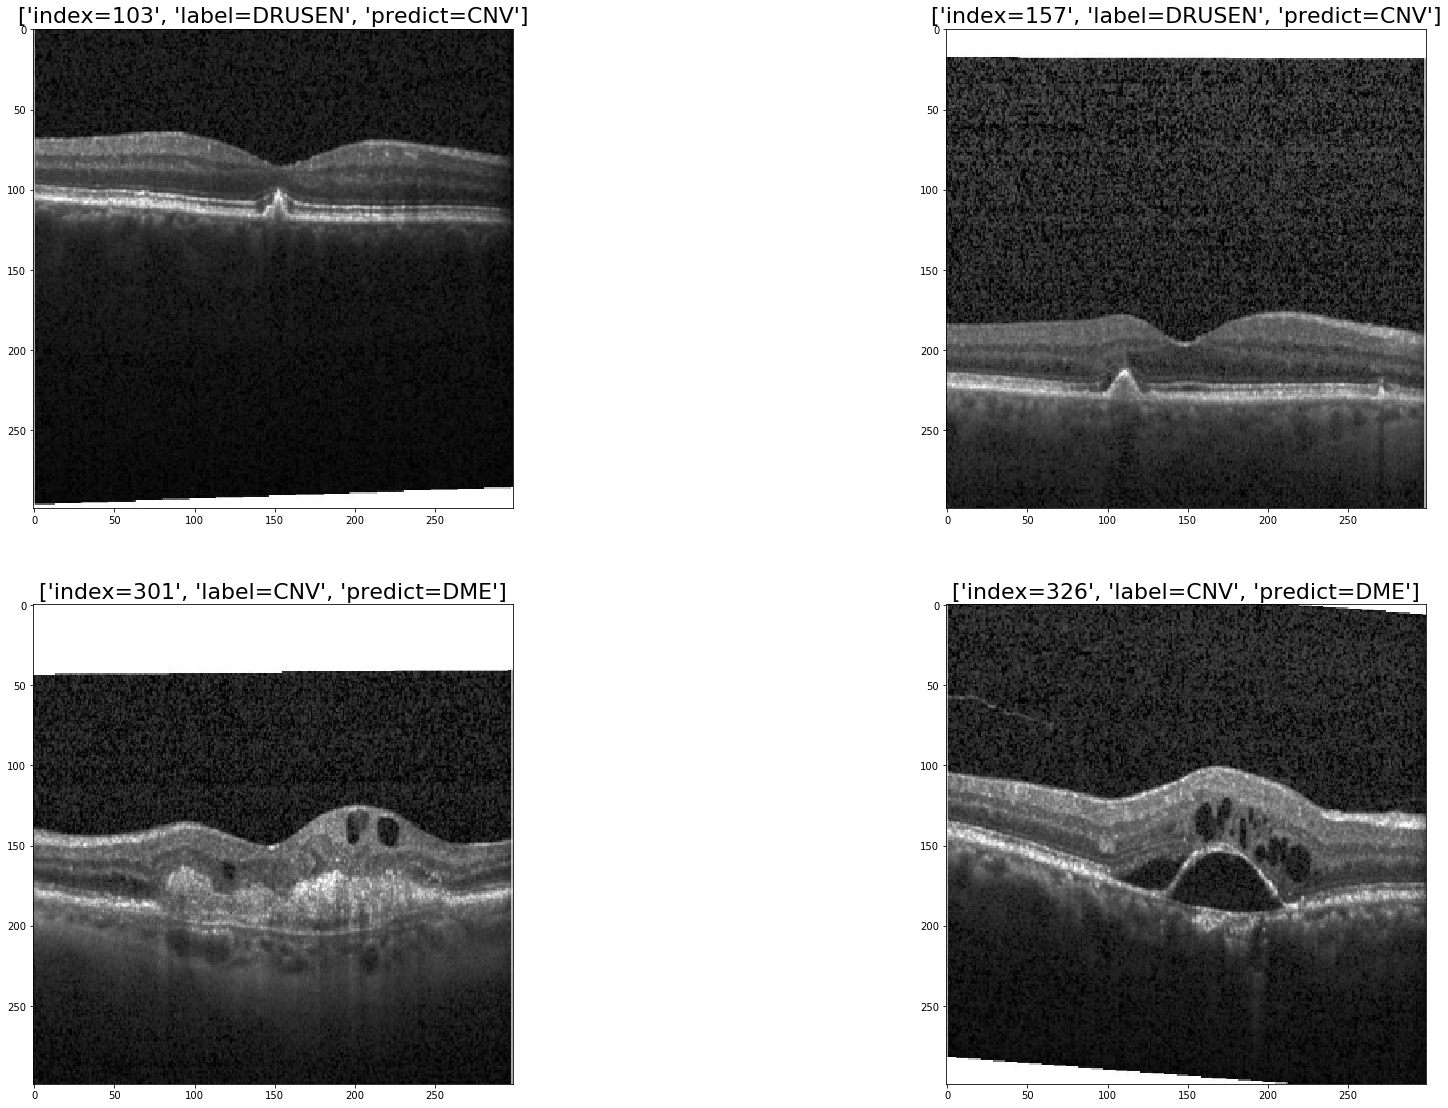

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
for i in range(len(wrongindex)) :
    plt.subplot(int(len(wrongindex)/2)+1 , 2, i+1 )
    plt.imshow(x_new_images_normalize[wrongindex[i]])   
    plt.gca().set_title(["index=" +str(wrongindex[i]),"label=" +str(new_df_wrong ['label_new'].iloc[i]),"predict=" +str(new_df_wrong ['predict_new'].iloc[i])], size=22)      

In [26]:
pd.crosstab(new_df['label_new'],new_df['predict_new'], rownames=['label'],colnames=['predict'])

predict,CNV,DME,DRUSEN,NORMAL
label,,,,
CNV,98,2,0,0
DME,0,100,0,0
DRUSEN,2,0,98,0
NORMAL,0,0,0,100


              precision    recall  f1-score   support

         CNV       0.98      0.98      0.98       100
         DME       0.98      1.00      0.99       100
      DRUSEN       1.00      0.98      0.99       100
      NORMAL       1.00      1.00      1.00       100

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



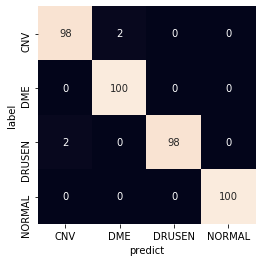

In [27]:
mapping = {'CNV': 0,'DME': 1,'DRUSEN': 2,'NORMAL': 3}
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(new_labels , prediction)
sns.heatmap(mat,square=True,annot=True,fmt='d',cbar=False,
           xticklabels=mapping , yticklabels=mapping)
plt.xlabel('predict')
plt.ylabel('label')

from sklearn.metrics import classification_report
print(classification_report(new_labels , prediction , target_names=mapping))